In [155]:
import os
import numpy as np
import nibabel as nib
import pandas as pd

In [156]:
# Set paths to the data directories
base_path = "/data/kaggledata"
train_images_path = f"{base_path}/train_images"
segmentations_path = f"{base_path}/segmentations"
binary_masks_path = f"{base_path}/working/binary_masks"
train_bbox_path = f"{base_path}/train_bounding_boxes.csv"

# **Split Data Using IDs**

In [55]:
from sklearn.model_selection import train_test_split

# Get patient IDs that have binary_masks
patient_ids = [os.path.splitext(f)[0] for f in os.listdir(binary_masks_path)]

# Split patients IDs into sets
train_ids, temp_ids = train_test_split(patient_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

print(f"Train: {len(train_ids)} patients\nVal: {len(val_ids)} patients\nTest: {len(test_ids)} patients")

Train: 60 patients
Val: 13 patients
Test: 14 patients


# **Generate Data for Model**

In [157]:
import torch
from torch.utils.data import Dataset
import cv2
import pydicom

class NiftiDicomDataset(Dataset):
    def __init__(self, patient_ids, image_dir, mask_dir, target_size=(256, 256)):
        self.patient_ids = patient_ids
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.target_size = target_size
        self.samples = self._preload_sample_indices()  # Preload valid (pid, slice_idx) pairs

    def _preload_sample_indices(self):
        samples = []
        for pid in self.patient_ids:
            mask_path = os.path.join(self.mask_dir, f"{pid}.nii")
            masks = nib.load(mask_path).get_fdata()
            dicom_dir = os.path.join(self.image_dir, pid)
            
            # Balance foreground/background images
            fg_count = 0
            bg_count = 0
            
            for slice_idx in range(masks.shape[0]):
                if np.any(masks[slice_idx] > 0):
                    fg_count += 1
                    samples.append((pid, slice_idx, True))  # (patient_id, slice_idx, is_foreground)
                elif fg_count > 3 * bg_count:
                    bg_count += 1
                    samples.append((pid, slice_idx, False))
        
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        pid, slice_idx, _ = self.samples[idx]
        
        # Load DICOM
        dicom_path = os.path.join(self.image_dir, pid, f"{slice_idx+1}.dcm")
        dicom = pydicom.dcmread(dicom_path)
        img = dicom.pixel_array.astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min())
        img = cv2.resize(img, self.target_size)  # [H, W]
        
        # Load mask
        mask_path = os.path.join(self.mask_dir, f"{pid}.nii")
        masks = nib.load(mask_path).get_fdata()
        mask = masks[slice_idx].astype(np.float32)
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)  # [H, W]
        
        # Convert to PyTorch tensors and add channel dimension
        img_tensor = torch.from_numpy(img).unsqueeze(0).float()  # [1, H, W]
        mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()  # [1, H, W]
        
        return img_tensor, mask_tensor  # Single sample

In [5]:
from torch.utils.data import DataLoader

train_dataset = NiftiDicomDataset(
    patient_ids=train_ids,
    image_dir=train_images_path,
    mask_dir=binary_masks_path,
    target_size=(256, 256)
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

In [6]:
val_dataset = NiftiDicomDataset(
    patient_ids=val_ids,
    image_dir=train_images_path,
    mask_dir=binary_masks_path,
    target_size=(256, 256)
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

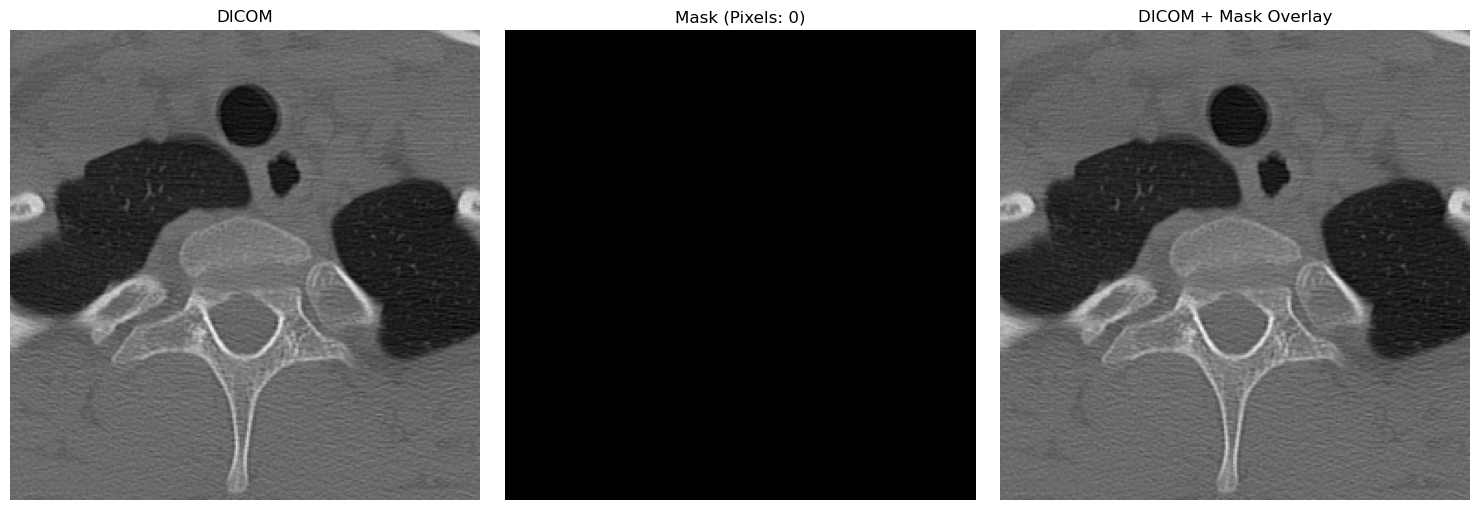

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def show_dicom_and_mask(dataloader, num_samples=3):
    # Get a batch from the dataloader
    images, masks = next(iter(dataloader))
    
    # Convert to numpy and remove batch/channel dimensions for plotting
    images = images.cpu().numpy()[:, 0, ...]  # [B, 1, H, W] -> [B, H, W]
    masks = masks.cpu().numpy()[:, 0, ...]    # [B, 1, H, W] -> [B, H, W]
    
    for j in range(min(num_samples, images.shape[0])):
        plt.figure(figsize=(15, 5))
        
        # Panel 1: DICOM image
        plt.subplot(1, 3, 1)
        plt.imshow(images[j], cmap='gray')
        plt.title("DICOM")
        plt.axis('off')
        
        # Panel 2: Binary mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[j], cmap='gray', vmin=0, vmax=1)
        plt.title(f"Mask (Pixels: {masks[j].sum():.0f})")
        plt.axis('off')
        
        # Panel 3: Overlay (blue)
        plt.subplot(1, 3, 3)
        plt.imshow(images[j], cmap='gray')
        
        blue_mask = np.zeros((*masks[j].shape, 4))
        blue_mask[..., 2] = 1  # Blue channel
        blue_mask[..., 3] = masks[j] * 0.5  # Alpha
        
        plt.imshow(blue_mask)
        plt.title("DICOM + Mask Overlay")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

show_dicom_and_mask(train_dataloader, num_samples=1)



# **Histogram Equalization**

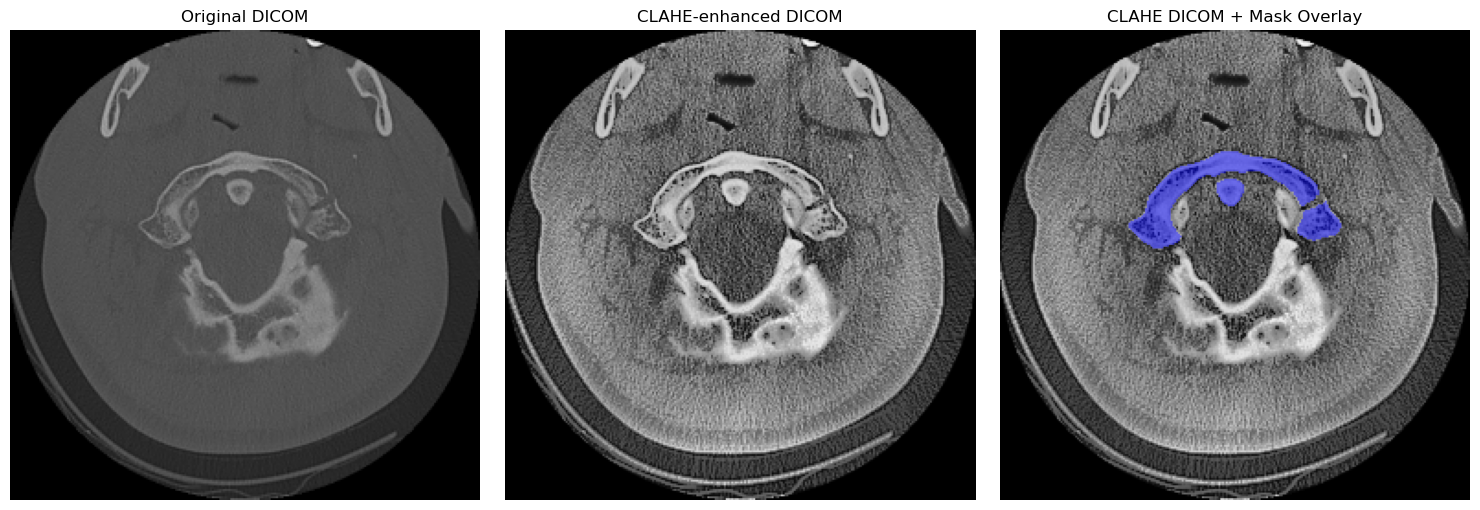

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure  # For CLAHE

def show_dicom_and_mask(dataloader, num_samples=3):
    # Get a batch from the dataloader
    images, masks = next(iter(dataloader))
    
    # Convert to numpy and remove batch/channel dimensions for plotting
    images = images.cpu().numpy()[:, 0, ...]  # [B, 1, H, W] -> [B, H, W]
    masks = masks.cpu().numpy()[:, 0, ...]    # [B, 1, H, W] -> [B, H, W]
    
    for j in range(min(num_samples, images.shape[0])):
        plt.figure(figsize=(15, 5))
        
        # Apply CLAHE to the DICOM image
        img_clahe = exposure.equalize_adapthist(
            images[j], 
            clip_limit=0.03,  # Adjust this for more/less contrast enhancement
            kernel_size=(64, 64)  # Size of local regions for equalization
        )
        
        # Panel 1: Original DICOM image
        plt.subplot(1, 3, 1)
        plt.imshow(images[j], cmap='gray')
        plt.title("Original DICOM")
        plt.axis('off')
        
        # Panel 2: CLAHE-enhanced DICOM image
        plt.subplot(1, 3, 2)
        plt.imshow(img_clahe, cmap='gray')
        plt.title("CLAHE-enhanced DICOM")
        plt.axis('off')
        
        # Panel 3: Overlay (blue) with CLAHE-enhanced image
        plt.subplot(1, 3, 3)
        plt.imshow(img_clahe, cmap='gray')
        
        blue_mask = np.zeros((*masks[j].shape, 4))
        blue_mask[..., 2] = 1  # Blue channel
        blue_mask[..., 3] = masks[j] * 0.5  # Alpha
        
        plt.imshow(blue_mask)
        plt.title("CLAHE DICOM + Mask Overlay")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

show_dicom_and_mask(train_dataloader, num_samples=1)

# **Model**

In [58]:
# Some training hyperparameters
EPOCHS = 10
T_MAX = EPOCHS * len(train_dataloader)
OUT_CLASSES = 1

In [12]:
!pip install lightning

/bin/bash: /home/vonaesch/miniconda3/envs/cv-env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 36.5 MB/s eta 0:00:00


In [59]:
import pytorch_lightning as pl

In [60]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

class VertebraeModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        for param in self.model.encoder.parameters():
            param.requires_grad = False
        
        # preprocessing parameters for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # using dice loss
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metrics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        #image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        #mask = batch["mask"]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # Compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [25]:
model = VertebraeModel("Unet", "resnet34", in_channels=1, out_classes=1)

In [26]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Unet     | 24.4 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
3.2 M     Trainable params
21.3 M    Non-trainable params
24.4 M    Total params
97.720    Total estimated model params size (MB)
189       Modules in train mode
0         Modules in eval m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [33]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=val_dataloader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_per_image_iou': 0.8422051668167114, 'valid_dataset_iou': 0.8655549883842468}]


# **Testing**

In [34]:
test_dataset = NiftiDicomDataset(
    patient_ids=test_ids,
    image_dir=train_images_path,
    mask_dir=binary_masks_path,
    target_size=(256, 256)
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

In [35]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/vonaesch/miniconda3/envs/cv-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.6998868584632874, 'test_dataset_iou': 0.6646134853363037}]


# **Visualize Results**

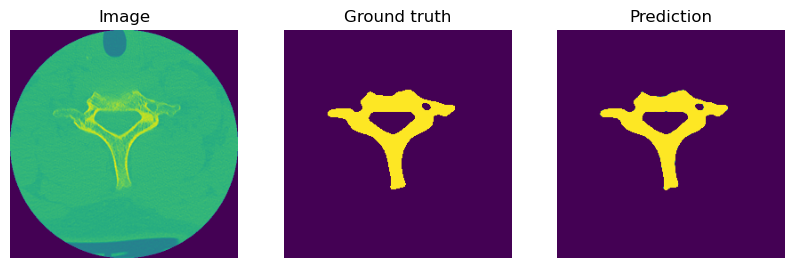

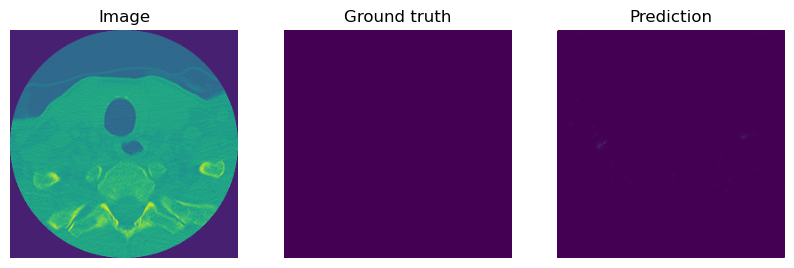

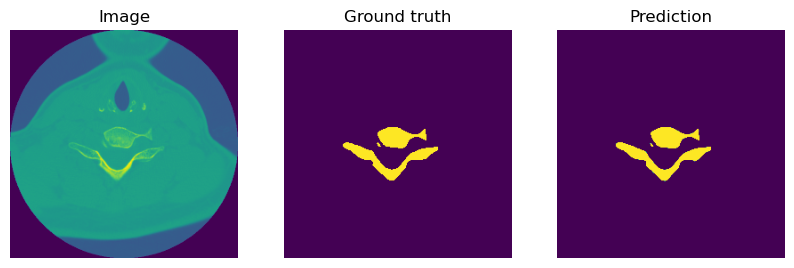

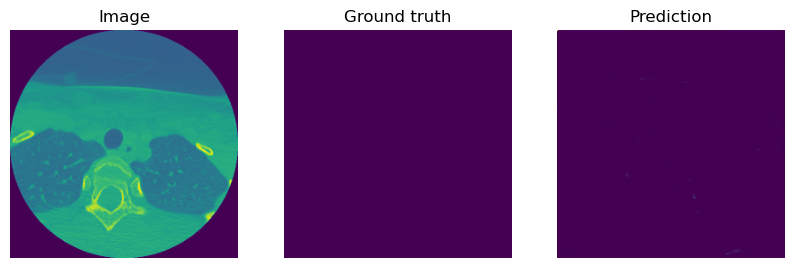

In [46]:
batch = next(iter(test_dataloader))
images, masks = batch  # Unpack as list/tuple instead of dict

with torch.no_grad():
    model.eval()
    logits = model(images)  # Use images instead of batch["image"]

pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break

        image, mask = batch

In [1]:
batch = next(iter(test_dataloader))
images, masks = batch  # Unpack as list/tuple instead of dict

with torch.no_grad():
    model.eval()
    logits = model(images)  # Use images instead of batch["image"]

pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        
        # DICOM Image (grayscale)
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')  # Black and white
        plt.title("Image")
        plt.axis('off')
        
        # Ground Truth Mask (blue on white)
        plt.subplot(1, 3, 2)
        # Create custom colormap: 0=white, 1=blue
        gt_cmap = plt.cm.colors.ListedColormap(['white', 'blue'])
        plt.imshow(gt_mask.numpy().squeeze(), cmap=gt_cmap, vmin=0, vmax=1)
        plt.title("Ground Truth")
        plt.axis('off')
        
        # Predicted Mask (blue on white)
        plt.subplot(1, 3, 3)
        pr_cmap = plt.cm.colors.ListedColormap(['white', 'blue'])
        plt.imshow(pr_mask.numpy().squeeze(), cmap=pr_cmap, vmin=0, vmax=1)
        plt.title("Prediction")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        break

NameError: name 'test_dataloader' is not defined

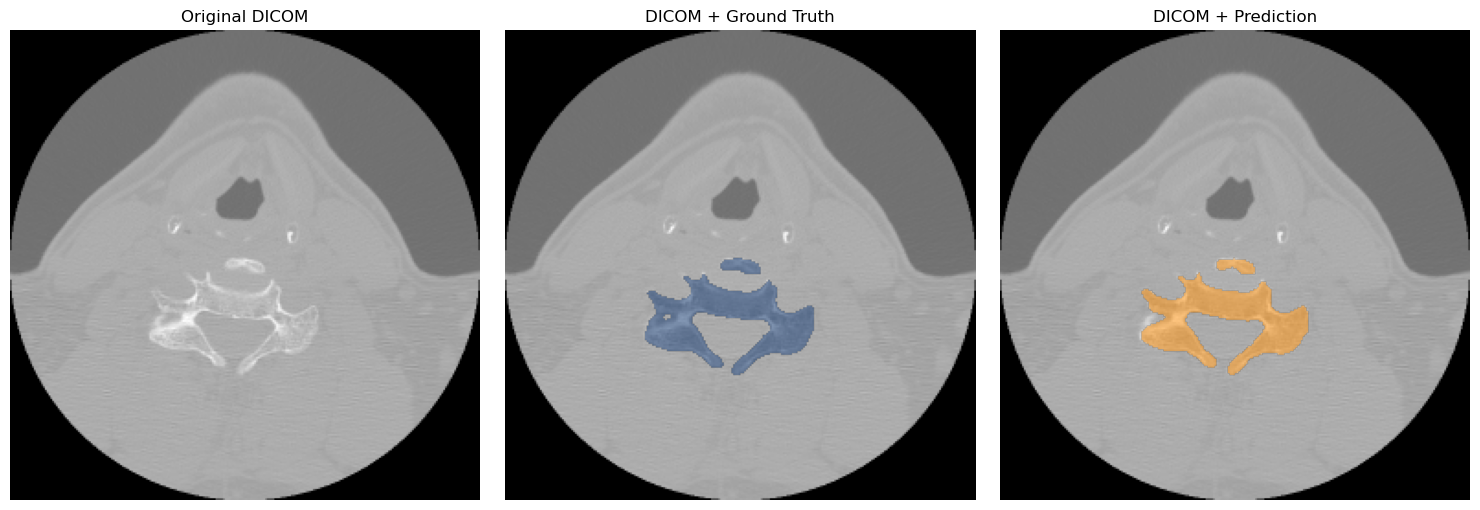

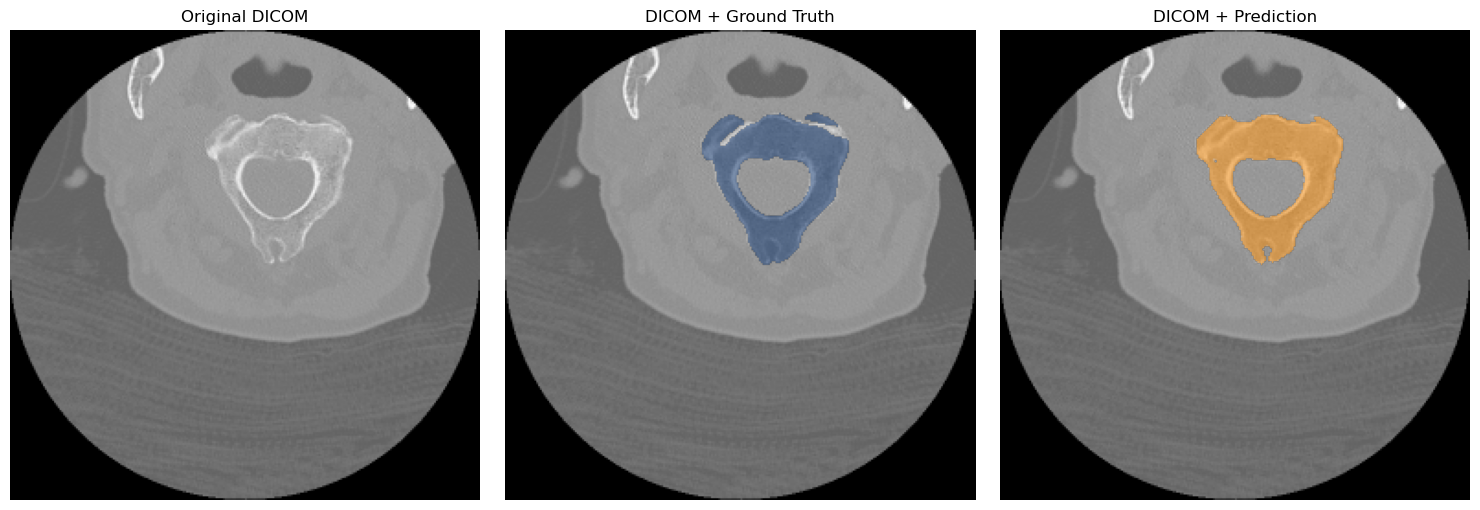

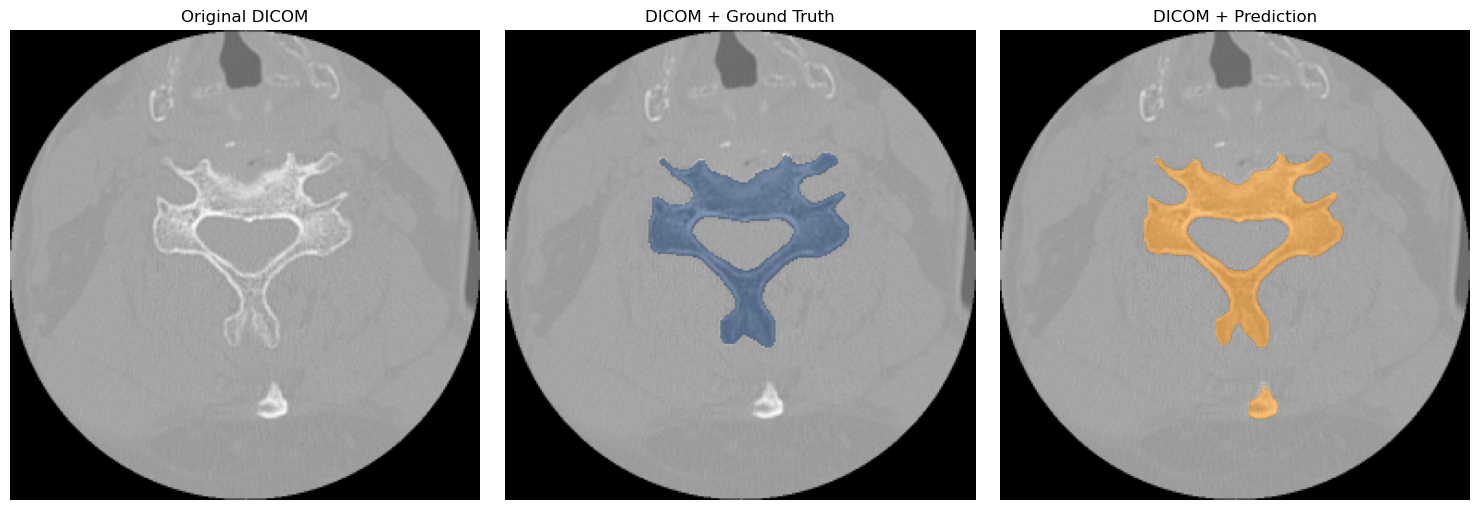

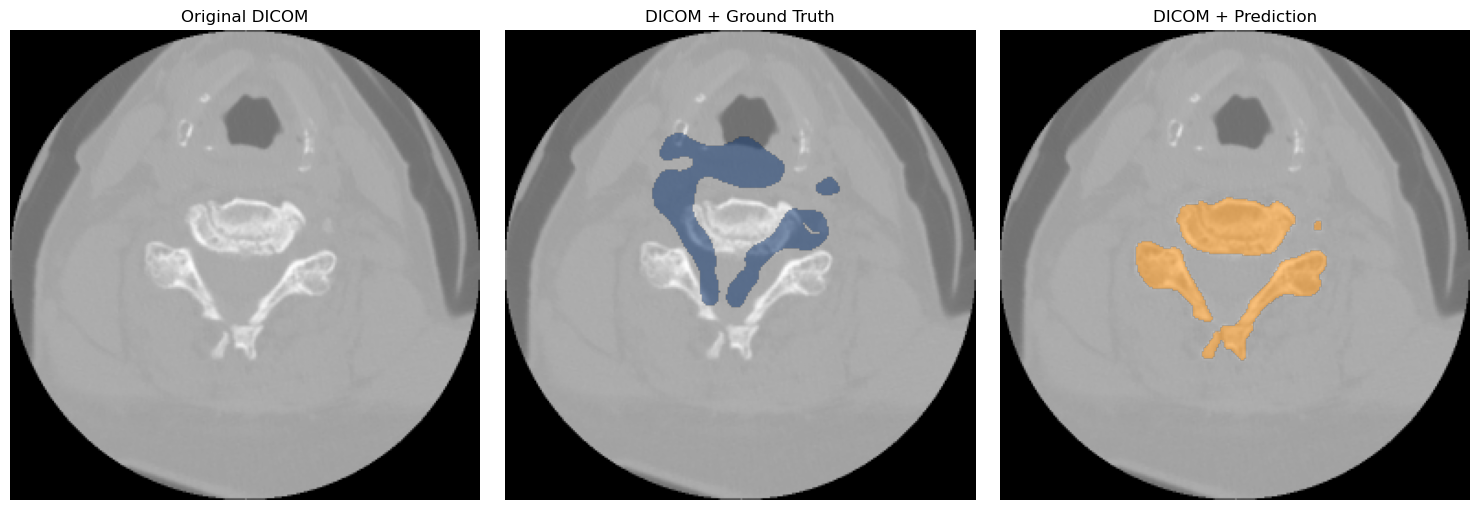

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Create custom orange colormap (white -> orange)
orange_cmap = LinearSegmentedColormap.from_list('orange_cmap', ['white', 'darkorange'])

batch = next(iter(test_dataloader))
images, masks = batch

with torch.no_grad():
    model.eval()
    logits = model(images)

pr_masks = logits.sigmoid()

for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx > 4:
        break
        
    img = image.numpy().transpose(1, 2, 0).squeeze()
    gt = gt_mask.numpy().squeeze()
    pr = pr_mask.numpy().squeeze()
    
    plt.figure(figsize=(15, 5))
    
    # 1. Original DICOM
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original DICOM")
    plt.axis('off')
    
    # 2. DICOM + Ground Truth (Blue)
    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='gray')
    plt.imshow(np.ma.masked_where(gt < 0.5, gt), 
               cmap='Blues', alpha=0.5, vmin=0, vmax=1)
    plt.title("DICOM + Ground Truth")
    plt.axis('off')
    
    # 3. DICOM + Prediction (Orange)
    plt.subplot(1, 3, 3)
    plt.imshow(img, cmap='gray')
    plt.imshow(np.ma.masked_where(pr < 0.5, pr), 
               cmap=orange_cmap, alpha=0.5, vmin=0, vmax=1)
    plt.title("DICOM + Prediction")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# **Not sure if these saving methods work or not**

In [ ]:
# After training model, save it to a directory
save_path = f"{base_path}/working/saved_models"


# Create output directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)
os.makedirs("/data/kaggledata/working/saved_models/model_1", exist_ok=True)

model.save_pretrained("/data/kaggledata/working/saved_models/model_1")

In [27]:
# After training model, save it to a directory
model_path = f"{base_path}/working/saved_models"

# Create output directory if it doesn't exist
os.makedirs(model_path, exist_ok=True)

save_path = "/data/kaggledata/working/saved_models/model_1"
os.makedirs(save_path, exist_ok=True)  # Create directory if needed

# Save the model checkpoint
trainer.save_checkpoint(f"{save_path}/lightning_model.ckpt")

# **Saving/Checkpoints?**

In [29]:
save_path = f"{base_path}/working/saved_models"
ckpt_path = f"{save_path}/lightning_model.ckpt"
print(f"Checkpoint exists: {os.path.exists(ckpt_path)}")
# Check file size (should be > 0)
file_size = os.path.getsize(ckpt_path) / (1024 * 1024)  # Size in MB
print(f"Checkpoint size: {file_size:.2f} MB")

Checkpoint exists: True
Checkpoint size: 117.43 MB


In [30]:
checkpoint = torch.load(ckpt_path, map_location="cpu")
print("Checkpoint keys:", checkpoint.keys())

Checkpoint keys: dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])


In [31]:
print("Weight keys:", checkpoint['state_dict'].keys())

Weight keys: odict_keys(['std', 'mean', 'model.encoder.conv1.weight', 'model.encoder.bn1.weight', 'model.encoder.bn1.bias', 'model.encoder.bn1.running_mean', 'model.encoder.bn1.running_var', 'model.encoder.bn1.num_batches_tracked', 'model.encoder.layer1.0.conv1.weight', 'model.encoder.layer1.0.bn1.weight', 'model.encoder.layer1.0.bn1.bias', 'model.encoder.layer1.0.bn1.running_mean', 'model.encoder.layer1.0.bn1.running_var', 'model.encoder.layer1.0.bn1.num_batches_tracked', 'model.encoder.layer1.0.conv2.weight', 'model.encoder.layer1.0.bn2.weight', 'model.encoder.layer1.0.bn2.bias', 'model.encoder.layer1.0.bn2.running_mean', 'model.encoder.layer1.0.bn2.running_var', 'model.encoder.layer1.0.bn2.num_batches_tracked', 'model.encoder.layer1.1.conv1.weight', 'model.encoder.layer1.1.bn1.weight', 'model.encoder.layer1.1.bn1.bias', 'model.encoder.layer1.1.bn1.running_mean', 'model.encoder.layer1.1.bn1.running_var', 'model.encoder.layer1.1.bn1.num_batches_tracked', 'model.encoder.layer1.1.conv2.

# **Dilate Masks**

In [49]:
def dilate_mask(original_mask):
    # Define a kernel (structuring element)
    kernel_size = 20  # Adjust this for more/less dilation
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Perform dilation
    dilated_mask = cv2.dilate(original_mask, kernel, iterations=1)
    return dilated_mask

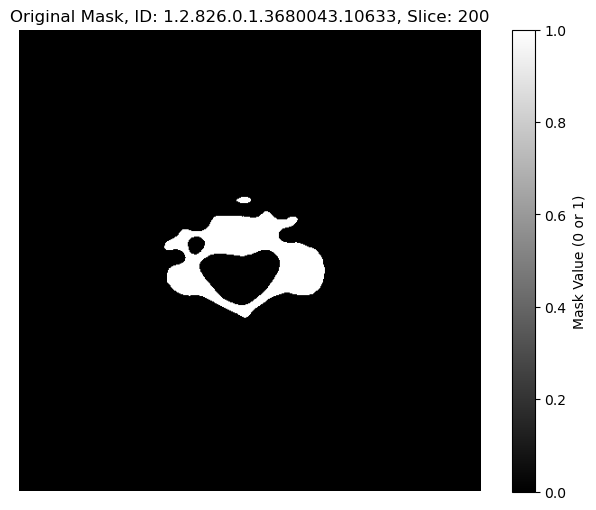

<class 'numpy.ndarray'>


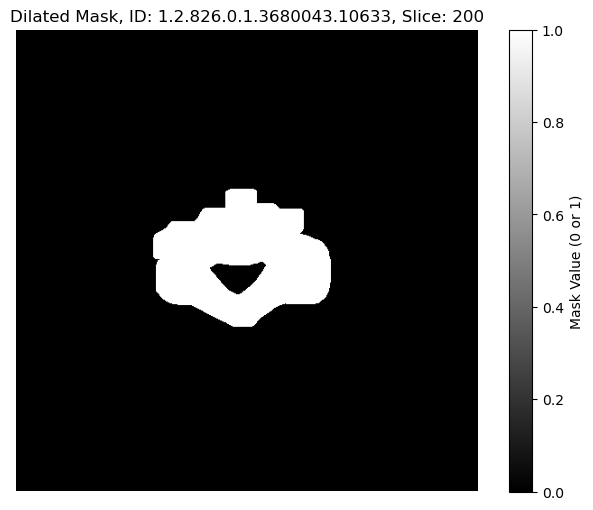

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assumes a binary mask
path = f"{binary_masks_path}/1.2.826.0.1.3680043.10633.nii"
nifti_mask = nib.load(path)
mask_data = nifti_mask.get_fdata()
original_mask = mask_data[200,:,:]


plt.figure(figsize=(8, 6))
plt.imshow(original_mask, cmap='gray')  # 'gray' colormap for binary
plt.title("Original Mask, ID: 1.2.826.0.1.3680043.10633, Slice: 200")
plt.colorbar(label="Mask Value (0 or 1)")
plt.axis('off')  # Hide axes if needed
plt.show()

# Perform dilation
dilated_mask = dilate_mask(original_mask)
print(type(dilated_mask))

plt.figure(figsize=(8, 6))
plt.imshow(dilated_mask, cmap='gray')  # 'gray' colormap for binary
plt.title("Dilated Mask, ID: 1.2.826.0.1.3680043.10633, Slice: 200")
plt.colorbar(label="Mask Value (0 or 1)")
plt.axis('off')  # Hide axes if needed
plt.show()

# **Predict Masks for IDs with Bounding Boxes that are Missing Segmentations**

In [158]:
import torch

save_path = f"{base_path}/working/saved_models"
ckpt_path = "/data/kaggledata/working/saved_models/model_1/lightning_model.ckpt"

# Load checkpoint
checkpoint = torch.load(ckpt_path, map_location="cpu")

# Initialize model
model = VertebraeModel("Unet", "resnet34", in_channels=1, out_classes=1)

# Load weights
if 'state_dict' in checkpoint:
    model.load_state_dict(checkpoint['state_dict'])
else:  # if the checkpoint is the state_dict directly
    model.load_state_dict(checkpoint)

# Set to eval mode
model.eval()

VertebraeModel(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): 

In [159]:
def dilate_mask(original_mask):
    # Define a kernel
    kernel_size = 20  # Adjust this for more/less dilation
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Perform dilation
    dilated_mask = cv2.dilate(original_mask, kernel, iterations=1)
    return dilated_mask

<class 'numpy.ndarray'>
(256, 256)


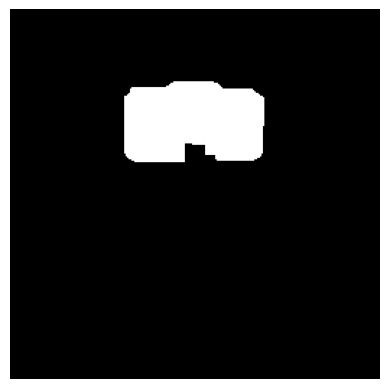

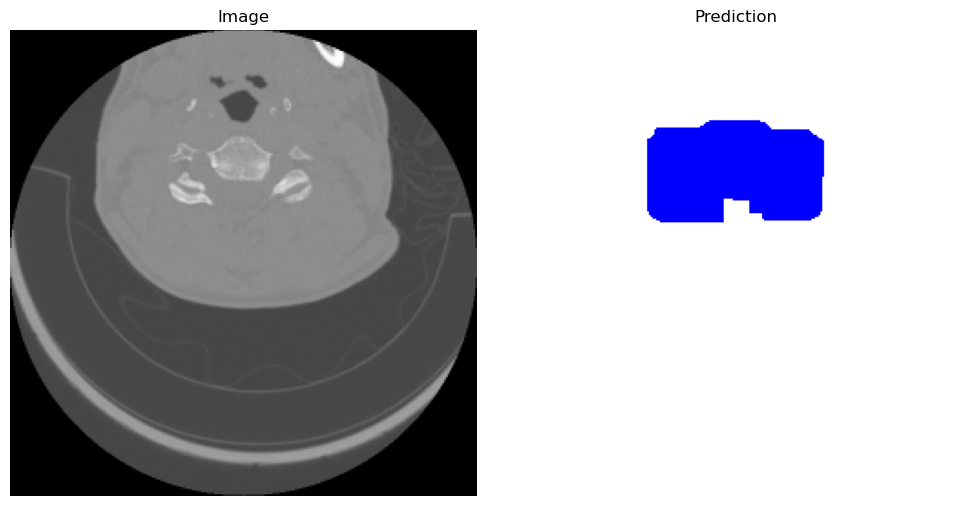

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [167]:
dicom_path = "/data/kaggledata/train_images/1.2.826.0.1.3680043.6555/200.dcm"
dicom = pydicom.dcmread(dicom_path)
img = dicom.pixel_array.astype(np.float32)
img = (img - img.min()) / (img.max() - img.min())
img = cv2.resize(img, (256, 256))

# Convert to PyTorch tensors and add channel dimension
img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).float()  # [1, 1, H, W]

with torch.no_grad():
    output_tensor = model(img_tensor)
    #output_tensor = output_tensor.squeeze(0)

# Convert predicted mask to numpy binary mask
threshold = 0.5
binary_mask = (output_tensor.sigmoid() > threshold).float()
binary_mask = binary_mask.byte()
binary_mask_np = binary_mask.squeeze(0).squeeze(0).numpy()

# Dilate mask and convert/safe as JPEG
directory = Path(f"{base_path}/working/predicted_masks/1.2.826.0.1.3680043.6555")
directory.mkdir(parents=True, exist_ok=True)

predicted_mask_save_path = f"{base_path}/working/predicted_masks/1.2.826.0.1.3680043.6555/200.jpeg"
binary_mask_np_dilated = dilate_mask(binary_mask_np)
binary_mask_np_dilated = binary_mask_np_dilated * 255  # Now 0=black, 255=white
cv2.imwrite(predicted_mask_save_path, binary_mask_np_dilated, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

print(type(binary_mask_np_dilated))
print(binary_mask_np_dilated.shape)


img2 = cv2.imread(predicted_mask_save_path, 0)

plt.imshow(img2, cmap='gray') # Use 'gray' colormap for grayscale display
plt.axis('off') # Turn off axis labels and ticks
plt.show()

plt.figure(figsize=(10, 5))

# DICOM Image (grayscale)
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')  # Black and white
plt.title("Image")
plt.axis('off')
# Predicted Mask (blue on white)
plt.subplot(1, 2, 2)
pr_cmap = plt.cm.colors.ListedColormap(['white', 'blue'])
plt.imshow(binary_mask_np_dilated, cmap=pr_cmap, vmin=0, vmax=1)
plt.title("Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()

print(binary_mask.numpy().squeeze(0).squeeze(0))


In [ ]:

plt.figure(figsize=(10, 5))

# DICOM Image (grayscale)
plt.subplot(1, 3, 1)
plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')  # Black and white
plt.title("Image")
plt.axis('off')

# Ground Truth Mask (blue on white)
plt.subplot(1, 3, 2)
# Create custom colormap: 0=white, 1=blue
gt_cmap = plt.cm.colors.ListedColormap(['white', 'blue'])
plt.imshow(gt_mask.numpy().squeeze(), cmap=gt_cmap, vmin=0, vmax=1)
plt.title("Ground Truth")
plt.axis('off')

# Predicted Mask (blue on white)
plt.subplot(1, 3, 3)
pr_cmap = plt.cm.colors.ListedColormap(['white', 'blue'])
plt.imshow(pr_mask.numpy().squeeze(), cmap=pr_cmap, vmin=0, vmax=1)
plt.title("Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()

In [85]:
# Patient IDs with segmentations
patient_ids_with_masks = [os.path.splitext(f)[0] for f in os.listdir(binary_masks_path)]
 
# Patient IDs with bounding boxes
df_bbox = pd.read_csv(train_bbox_path)
id_column = df_bbox.columns[0]
patient_ids_with_boxes = df_bbox[id_column].unique().tolist()

# Patient Ids with bounding boxes but no segmentations
patient_ids_with_masks_and_boxes = list(set(patient_ids_with_boxes).difference(set(patient_ids_with_masks)))
print(len(patient_ids_with_masks_and_boxes))

195


In [175]:
from pathlib import Path
import pydicom

predicted_mask_save_path = f"{base_path}/working/predicted_masks"

# Create output directory if it doesn't exist
os.makedirs(predicted_mask_save_path, exist_ok=True)

train_images_path_object = Path(train_images_path)
valid_ids = set(patient_ids_with_masks_and_boxes)
target_size = (256, 256)
threshold = 0.5

for patient_folder in train_images_path_object.iterdir():
    if patient_folder.is_dir() and patient_folder.name in valid_ids:
        # Make directory for patient if it doesn't exist
        patient_id = patient_folder.name
        patient_directory = Path(f"{base_path}/working/predicted_masks/{patient_id}")
        patient_directory.mkdir(parents=True, exist_ok=True)
        print(f"Starting partient id: {patient_id}")
        
        for dicom_file in patient_folder.iterdir():
            # Process dicom to use as model input
            predicted_mask_save_path = patient_directory / f"{dicom_file.stem}.jpeg"
            dicom_path = train_images_path_object / patient_folder.name / dicom_file.name
            dicom = pydicom.dcmread(dicom_path)
            img = dicom.pixel_array.astype(np.float32)
            img = (img - img.min()) / (img.max() - img.min())
            img = cv2.resize(img, target_size)

            # Convert to PyTorch tensors and add channel dimension
            img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).float()  # [1, 1, H, W]
            
            with torch.no_grad():
                output_tensor = model(img_tensor)

            # Convert predicted mask to numpy binary mask    
            binary_mask = (output_tensor.sigmoid() > threshold).float()
            binary_mask = binary_mask.byte()
            binary_mask_np = binary_mask.squeeze(0).squeeze(0).numpy()

            # Dilate mask and convert/safe as JPEG
            binary_mask_np_dilated = dilate_mask(binary_mask_np)
            binary_mask_np_dilated = binary_mask_np_dilated * 255  # Now 0=black, 255=white
            cv2.imwrite(str(predicted_mask_save_path), binary_mask_np_dilated, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

Starting partient id: 1.2.826.0.1.3680043.6620
Starting partient id: 1.2.826.0.1.3680043.7408
Starting partient id: 1.2.826.0.1.3680043.5482
Starting partient id: 1.2.826.0.1.3680043.28329
Starting partient id: 1.2.826.0.1.3680043.4553
Starting partient id: 1.2.826.0.1.3680043.7361
Starting partient id: 1.2.826.0.1.3680043.32046
Starting partient id: 1.2.826.0.1.3680043.21904
Starting partient id: 1.2.826.0.1.3680043.12095
Starting partient id: 1.2.826.0.1.3680043.20061
Starting partient id: 1.2.826.0.1.3680043.26034
Starting partient id: 1.2.826.0.1.3680043.12328
Starting partient id: 1.2.826.0.1.3680043.24307
Starting partient id: 1.2.826.0.1.3680043.30549
Starting partient id: 1.2.826.0.1.3680043.1476
Starting partient id: 1.2.826.0.1.3680043.30787
Starting partient id: 1.2.826.0.1.3680043.16806
Starting partient id: 1.2.826.0.1.3680043.15699
Starting partient id: 1.2.826.0.1.3680043.10579
Starting partient id: 1.2.826.0.1.3680043.21561
Starting partient id: 1.2.826.0.1.3680043.1712

In [87]:
dicom_path = train_images_path_object / patient_folder.name / dicom_file.name
print(dicom_path)

/data/kaggledata/train_images/1.2.826.0.1.3680043.6555/10.dcm


In [75]:
import os
base_path = "/data/kaggledata/working/saved_models/model_1/lightning_model.ckpt"
dir_path = base_path

if os.path.isdir(dir_path):
    print("Directory exists")

files = os.listdir(dir_path)
for file in files:
    print(file)

NotADirectoryError: [Errno 20] Not a directory: '/data/kaggledata/working/saved_models/model_1/lightning_model.ckpt'

In [70]:
cur_dir = os.getcwd()
print(cur_dir)

/home/vonaesch
